**COMS E6998.015 - PRAC DEEP LEARNING SYS - Fall 2024**

*Homework 1 Solutions || Submitted By: Vaibhaw K Shende, **vks2116** @ columbia.edu*

**Solution to Problem 3 - Learning Rate, Batch Size, FashionMNIST**

**Part 1 : Finding learning rate $lr_{min}$ and $lr_{max}$**

Training on device: cuda
Learning Rates: [1.00000000e-09 1.29154967e-08 1.66810054e-07 2.15443469e-06
 2.78255940e-05 3.59381366e-04 4.64158883e-03 5.99484250e-02
 7.74263683e-01 1.00000000e+01]
Learning Rate: 1.0e-09, Accuracy: 10.00%
Learning Rate: 1.3e-08, Accuracy: 10.00%
Learning Rate: 1.7e-07, Accuracy: 10.00%
Learning Rate: 2.2e-06, Accuracy: 31.49%
Learning Rate: 2.8e-05, Accuracy: 72.44%
Learning Rate: 3.6e-04, Accuracy: 82.80%
Learning Rate: 4.6e-03, Accuracy: 84.44%
Learning Rate: 6.0e-02, Accuracy: 10.07%
Learning Rate: 7.7e-01, Accuracy: 10.01%
Learning Rate: 1.0e+01, Accuracy: 9.79%


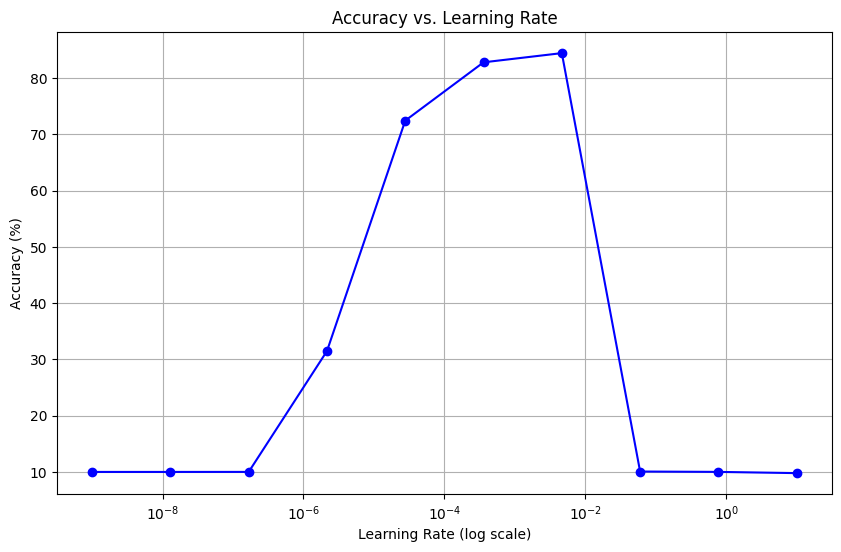

In [ ]:
##Part 1 : Plot the training loss as a function of learning rate.
##
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Setup Device for Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# Step 2: Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalization for FashionMNIST
])

# Download and load the FashionMNIST dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Step 3: Define Small Inception Model (from previous code)
class SmallInception(nn.Module):
    def __init__(self):
        super(SmallInception, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1, stride=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self._calculate_flatten_size()
        self.fc = nn.Linear(self.flatten_size, 10)

    def _calculate_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, 28, 28)
            dummy_output = self.forward_features(dummy_input)
            self.flatten_size = dummy_output.numel()

    def forward_features(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = self.pool2(torch.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Step 4: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
model = SmallInception().to(device)

# Step 5: Define Learning Rate Range and Training Function
def lr_range_test(model, trainloader, criterion, optimizer, lr_values, device, epochs=1):
    model.train()
    accuracy_per_lr = []  # Store accuracies for each learning rate

    for lr in lr_values:
        optimizer.param_groups[0]['lr'] = lr  # Set the learning rate for this iteration
        correct, total = 0, 0

        for epoch in range(epochs):
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Calculate accuracy
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        # Calculate and store the accuracy for this learning rate
        accuracy = 100.0 * correct / total
        accuracy_per_lr.append(accuracy)
        print(f"Learning Rate: {lr:.1e}, Accuracy: {accuracy:.2f}%")

    return accuracy_per_lr

# Define a range of learning rates (logarithmically spaced)
lr_values = np.logspace(-9, 1, 10)  # 10 values between 1e-9 and 10
print(f"Learning Rates: {lr_values}")

# Define optimizer (using Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Initial learning rate will be overwritten

# Step 6: Perform Learning Rate Range Test
accuracy_per_lr = lr_range_test(model, trainloader, criterion, optimizer, lr_values, device, epochs=1)

# Step 7: Plot Accuracy vs. Learning Rate
plt.figure(figsize=(10, 6))
plt.plot(lr_values, accuracy_per_lr, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Learning Rate')
plt.grid(True)
plt.show()


**Analysis:** Based on the high accuracy rates, the values of the values of $lr_min$ and $lr_max$ can range from 1e-05 to 1e-02 .

**Part 2: Implementing Cyclical Learning Rate Policy**

Training on device: cuda
Epoch [1/30], Loss: 0.5078, Accuracy: 81.74%
Epoch [2/30], Loss: 0.3801, Accuracy: 86.00%
Epoch [3/30], Loss: 0.3471, Accuracy: 87.45%
Epoch [4/30], Loss: 0.3288, Accuracy: 87.91%
Epoch [5/30], Loss: 0.3221, Accuracy: 88.20%
Epoch [6/30], Loss: 0.3175, Accuracy: 88.35%
Epoch [7/30], Loss: 0.2987, Accuracy: 89.08%
Epoch [8/30], Loss: 0.2962, Accuracy: 89.04%
Epoch [9/30], Loss: 0.2940, Accuracy: 89.16%
Epoch [10/30], Loss: 0.2897, Accuracy: 89.34%
Epoch [11/30], Loss: 0.2847, Accuracy: 89.55%
Epoch [12/30], Loss: 0.2810, Accuracy: 89.59%
Epoch [13/30], Loss: 0.2752, Accuracy: 89.82%
Epoch [14/30], Loss: 0.2703, Accuracy: 90.16%
Epoch [15/30], Loss: 0.2719, Accuracy: 89.93%
Epoch [16/30], Loss: 0.2658, Accuracy: 90.17%
Epoch [17/30], Loss: 0.2603, Accuracy: 90.44%
Epoch [18/30], Loss: 0.2602, Accuracy: 90.25%
Epoch [19/30], Loss: 0.2586, Accuracy: 90.52%
Epoch [20/30], Loss: 0.2615, Accuracy: 90.49%
Epoch [21/30], Loss: 0.2523, Accuracy: 90.70%
Epoch [22/30], Los

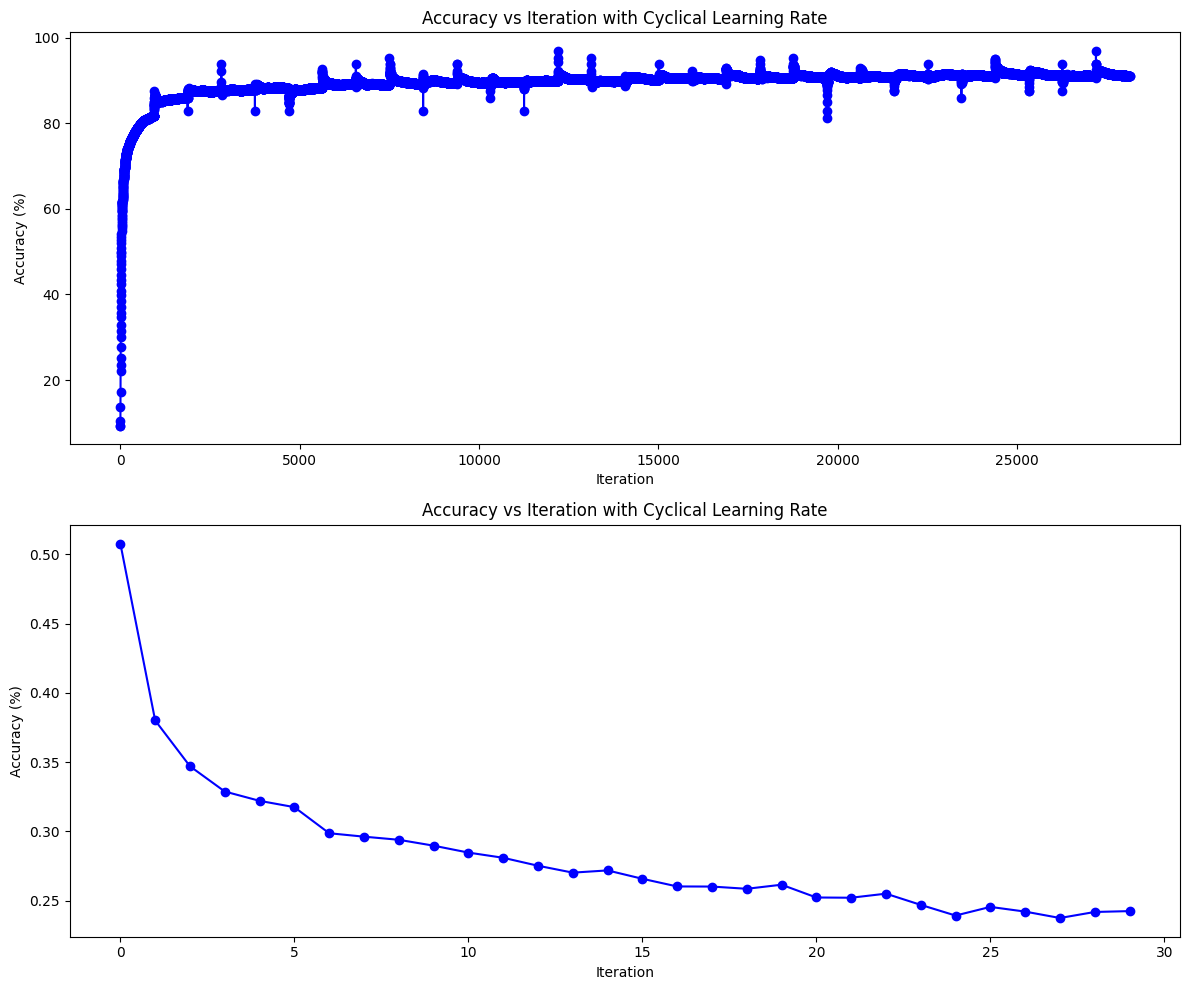

In [ ]:
##Part 2: Implementation with Cyclical Rate
#
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

# Step 1: Setup Device for Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# Step 2: Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalization for FashionMNIST
])

# Download and load the FashionMNIST dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Step 3: Define Model and Optimizer
class SmallInception(nn.Module):
    def __init__(self):
        super(SmallInception, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1, stride=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self._calculate_flatten_size()
        self.fc = nn.Linear(self.flatten_size, 10)

    def _calculate_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, 28, 28)
            dummy_output = self.forward_features(dummy_input)
            self.flatten_size = dummy_output.numel()

    def forward_features(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = self.pool2(torch.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = SmallInception().to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Initial learning rate

# Step 4: Implement Cyclical Learning Rate Policy
# Define min and max learning rates for the cycle
base_lr = 1e-5
max_lr = 1e-2

# Create the Cyclical Learning Rate scheduler
scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=5, mode='triangular', cycle_momentum=False)

# Step 5: Define Training Function with CLR and Accuracy Logging
def train_with_clr_and_accuracy(model, trainloader, criterion, optimizer, scheduler, device, epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []
    lr_values = []  # To store learning rate values for plotting
    iteration_accuracies = []  # Track accuracy at each iteration
    iterations = []  # Store iteration count

    iteration_count = 0

    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0

        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Step the scheduler to update learning rate
            scheduler.step()

            # Track the current learning rate and accuracy
            lr_values.append(scheduler.get_last_lr()[0])

            running_loss += loss.item()

            # Calculate accuracy for this batch and log it for plotting
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Store accuracy and iterations for plotting
            iteration_accuracies.append(100.0 * correct / total)
            iterations.append(iteration_count)
            iteration_count += 1

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100.0 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    return train_losses, train_accuracies, iteration_accuracies, iterations, lr_values

# Step 6: Train the Model and Collect Data
train_losses, train_accuracies, iteration_accuracies, iterations, lr_values = train_with_clr_and_accuracy(
    model, trainloader, criterion, optimizer, scheduler, device, epochs=30)

# Step 7: Plot Accuracy vs Iteration and Learning Rate vs Iteration
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot Accuracy vs Iteration
ax1.plot(iterations, iteration_accuracies, color='blue', marker='o')
ax1.set_title('Accuracy vs Iteration with Cyclical Learning Rate')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Accuracy (%)')

# Plot Training Loss
ax2.plot(range(len(train_losses)), train_losses, color='blue', marker='o')
#ax1.plot(iterations, iteration_accuracies, color='blue', marker='o')
ax2.set_title('Accuracy vs Iteration with Cyclical Learning Rate')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

**Part 3: Training network with increasing Batch Size**

Training on device: cuda


100%|██████████| 26421880/26421880 [00:02<00:00, 8823654.69it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 194829.54it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 912907.36it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22010476.04it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Training with Batch Size: 32
Batch Size: 32, Training Loss: 2.4317, Training Accuracy: 82.46%

Training with Batch Size: 64
Batch Size: 64, Training Loss: 2.2436, Training Accuracy: 83.71%

Training with Batch Size: 128
Batch Size: 128, Training Loss: 2.0650, Training Accuracy: 85.02%

Training with Batch Size: 256
Batch Size: 256, Training Loss: 1.9468, Training Accuracy: 85.88%

Training with Batch Size: 512
Batch Size: 512, Training Loss: 2.0064, Training Accuracy: 85.35%

Training with Batch Size: 1024
Batch Size: 1024, Training Loss: 2.3157, Training Accuracy: 83.42%

Training with Batch Size: 2048
Batch Size: 2048, Training Loss: 3.1635, Training Accuracy: 77.31%

Training with Batch Size: 4096
Batch Size: 4096, Training Loss: 4.7584, Training Accuracy: 67.70%

Training with Batch Size: 8192
Batch Size: 8192, Training Loss: 5.3634, Training Accuracy: 61.90%


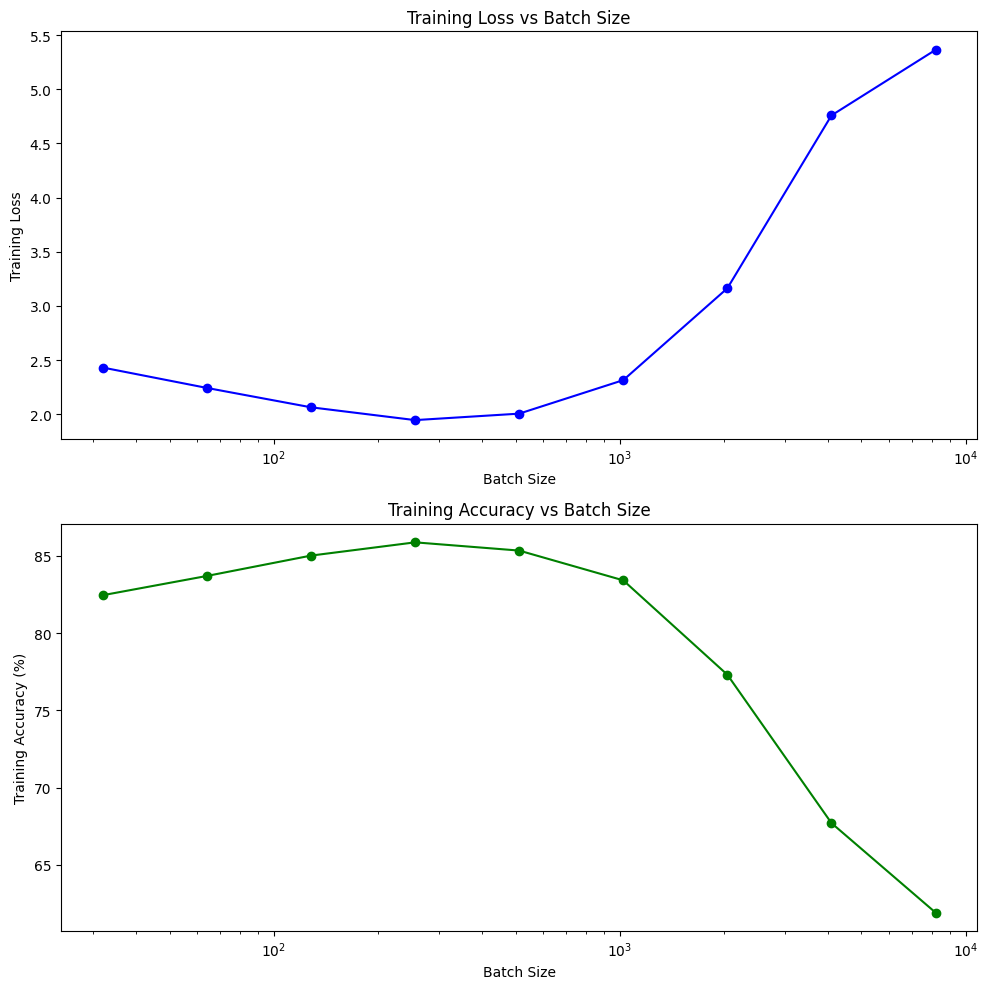

In [ ]:
##Part 3 : Fix learning rate to lrmax and train network
#          starting with batch size 32 and incrementally going upto 8192
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Setup Device for Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalization for FashionMNIST
])

# Download and load the FashionMNIST dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Define Model and Fixed Learning Rate
class SmallInception(nn.Module):
    def __init__(self):
        super(SmallInception, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1, stride=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self._calculate_flatten_size()
        self.fc = nn.Linear(self.flatten_size, 10)  # Final layer for 10 classes

    def _calculate_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, 28, 28)
            dummy_output = self.forward_features(dummy_input)
            self.flatten_size = dummy_output.numel()

    def forward_features(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = self.pool2(torch.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch size
        x = self.fc(x)
        return x

# Initialize the model and move to the selected device
model = SmallInception().to(device)

# Define loss function and fixed learning rate optimizer
criterion = nn.CrossEntropyLoss()
fixed_lr = 1e-2  # Fixed learning rate (choose the same `max_lr` value from the previous experiment)

# Train the Model with Increasing Batch Sizes
batch_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]  # Batch sizes to experiment with
train_losses = []  # To store training loss for each batch size
train_accuracies = []  # To store training accuracy for each batch size

# Function to train the model with different batch sizes
def train_with_batch_size(model, trainset, batch_size, criterion, optimizer, device, epochs=1):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / len(trainloader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

# Train the model with different batch sizes and record results
for batch_size in batch_sizes:
    print(f"\nTraining with Batch Size: {batch_size}")

    # Reinitialize the model and optimizer for each batch size
    model = SmallInception().to(device)
    optimizer = optim.Adam(model.parameters(), lr=fixed_lr)

    # Train and measure the results
    train_loss, train_accuracy = train_with_batch_size(model, trainset, batch_size, criterion, optimizer, device, epochs=5)

    print(f"Batch Size: {batch_size}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

# Plot Training Loss and Accuracy vs Batch Size
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot Training Loss vs. Batch Size
ax1.plot(batch_sizes, train_losses, color='blue', marker='o')
ax1.set_xscale('log')
ax1.set_title('Training Loss vs Batch Size')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Training Loss')

# Plot Training Accuracy vs. Batch Size
ax2.plot(batch_sizes, train_accuracies, color='green', marker='o')
ax2.set_xscale('log')
ax2.set_title('Training Accuracy vs Batch Size')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Training Accuracy (%)')

plt.tight_layout()
plt.show()


**Analysis:** The cyclical learning rate policy offers better generalization by encouraging the model to explore different regions of the loss surface, while larger batch sizes can lead to overfitting, with a fixed learning rate